# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/traffic-signs-data/train.p'
testing_file = './data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [8]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random
import numpy as np

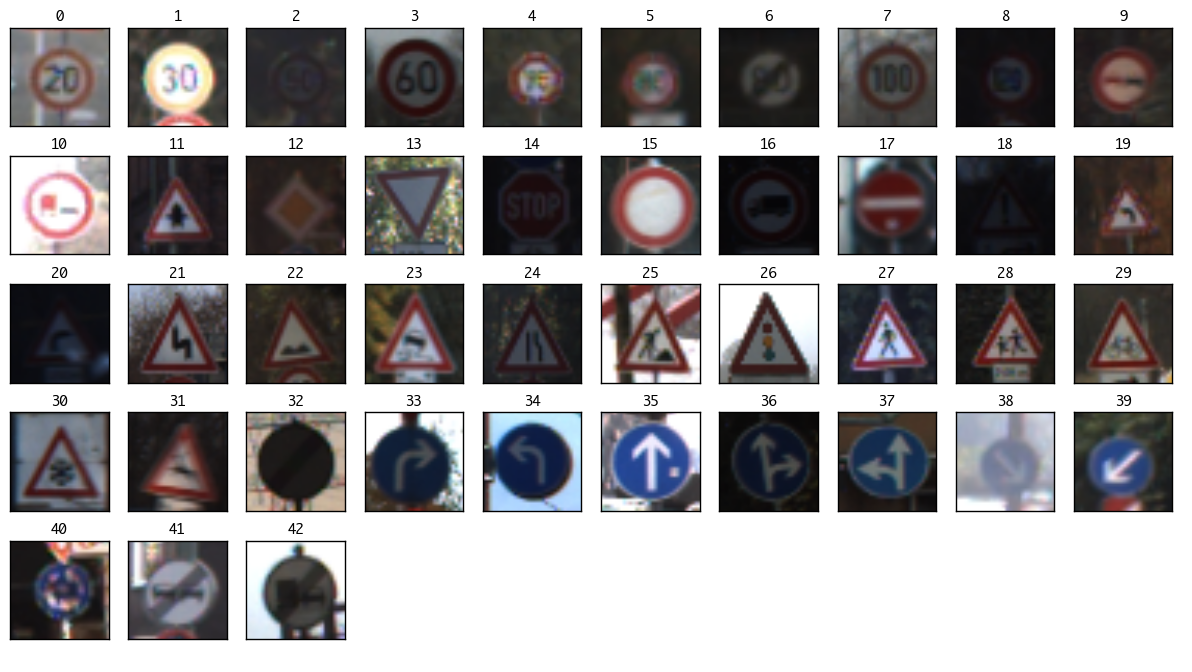

In [136]:
n_cols = 10
n_rows = int(np.ceil(n_classes / n_cols))
f, axarr = plt.subplots(n_rows, n_cols, figsize=(15,8))
for i in range(int(n_rows * n_cols)):
    ax = axarr[i // n_cols][i % n_cols]
    if i < n_classes:
        index = random.choice(np.where(y_train == i)[0])  #pick random item from class i
        image = X_train[index].squeeze()
        ax.imshow(image)
        ax.set_title(str(i))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.axis('off')

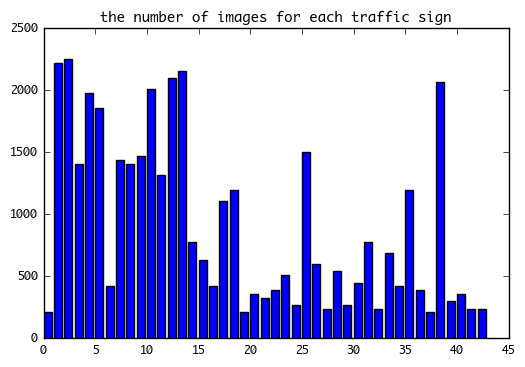

In [135]:
signs, n_signs = np.unique(y_train, return_counts=True)
plt.bar(signs, n_signs)
plt.title("the number of images for each traffic sign")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [173]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
# Get randomized datasets for training and validation
X_tr, X_validation, y_tr, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=832289)

len(X_tr), len(X_validation), len(X_test)

(31367, 7842, 12630)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [190]:
import tensorflow as tf
import math
from tqdm import tqdm

In [221]:
### Implement LeNet-5
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    #from IPython.core.debugger import Tracer; Tracer()()

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    layer1 = tf.nn.bias_add(tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID'), b1)

    # Activation.
    layer1 = tf.nn.relu(layer1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1 = tf.nn.max_pool(layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    layer2 = tf.nn.bias_add(tf.nn.conv2d(layer1, W2, strides=[1, 1, 1, 1], padding='VALID'),
                                             b2)
    
    # Activation.
    layer2 = tf.nn.relu(layer2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Flatten. Input = 5x5x16. Output = 400.
    layer2 = flatten(layer2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    layer3 = tf.add(tf.matmul(layer2, W3), b3)
    
    # Activation.
    layer3 = tf.nn.relu(layer3)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    layer4 = tf.add(tf.matmul(layer3, W4), b4)
    
    # Activation.
    layer4 = tf.nn.relu(layer4)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    W5 = tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(layer4, W5), b5)    

    return logits

In [220]:
tf.reset_default_graph()

In [214]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [215]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [216]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [217]:
EPOCHS = 60
BATCH_SIZE = 128

Epoch  1/60: 100%|██████████| 246/246 [00:23<00:00, 10.30batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.14batches/s]


EPOCH 1 ...
Training Accuracy = 0.783
Validation Accuracy = 0.766



Epoch  2/60: 100%|██████████| 246/246 [00:23<00:00, 10.60batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.10batches/s]


EPOCH 2 ...
Training Accuracy = 0.910
Validation Accuracy = 0.882



Epoch  3/60: 100%|██████████| 246/246 [00:23<00:00, 11.91batches/s]0:   0%|          | 1/246 [00:00<00:30,  7.93batches/s]


EPOCH 3 ...
Training Accuracy = 0.948
Validation Accuracy = 0.922



Epoch  4/60: 100%|██████████| 246/246 [00:23<00:00, 12.43batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.27batches/s]


EPOCH 4 ...
Training Accuracy = 0.967
Validation Accuracy = 0.940



Epoch  5/60: 100%|██████████| 246/246 [00:23<00:00, 12.11batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.09batches/s]


EPOCH 5 ...
Training Accuracy = 0.964
Validation Accuracy = 0.940



Epoch  6/60: 100%|██████████| 246/246 [00:23<00:00, 10.35batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.12batches/s]


EPOCH 6 ...
Training Accuracy = 0.980
Validation Accuracy = 0.952



Epoch  7/60: 100%|██████████| 246/246 [00:23<00:00, 10.62batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.22batches/s]


EPOCH 7 ...
Training Accuracy = 0.974
Validation Accuracy = 0.948



Epoch  8/60: 100%|██████████| 246/246 [00:22<00:00, 12.40batches/s]0:   0%|          | 1/246 [00:00<00:35,  6.86batches/s]


EPOCH 8 ...
Training Accuracy = 0.972
Validation Accuracy = 0.942



Epoch  9/60: 100%|██████████| 246/246 [00:23<00:00, 10.32batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.09batches/s]


EPOCH 9 ...
Training Accuracy = 0.983
Validation Accuracy = 0.954



Epoch 10/60: 100%|██████████| 246/246 [00:23<00:00, 12.25batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.31batches/s]


EPOCH 10 ...
Training Accuracy = 0.985
Validation Accuracy = 0.959



Epoch 11/60: 100%|██████████| 246/246 [00:22<00:00, 10.75batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.17batches/s]


EPOCH 11 ...
Training Accuracy = 0.983
Validation Accuracy = 0.958



Epoch 12/60: 100%|██████████| 246/246 [00:22<00:00, 12.35batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.32batches/s]


EPOCH 12 ...
Training Accuracy = 0.982
Validation Accuracy = 0.958



Epoch 13/60: 100%|██████████| 246/246 [00:22<00:00, 10.77batches/s]0:   0%|          | 1/246 [00:00<00:35,  6.84batches/s]


EPOCH 13 ...
Training Accuracy = 0.986
Validation Accuracy = 0.963



Epoch 14/60: 100%|██████████| 246/246 [00:22<00:00, 10.77batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.20batches/s]


EPOCH 14 ...
Training Accuracy = 0.978
Validation Accuracy = 0.953



Epoch 15/60: 100%|██████████| 246/246 [00:22<00:00, 10.75batches/s]0:   0%|          | 1/246 [00:00<00:34,  7.17batches/s]


EPOCH 15 ...
Training Accuracy = 0.988
Validation Accuracy = 0.961



Epoch 16/60: 100%|██████████| 246/246 [00:23<00:00, 10.65batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.40batches/s]


EPOCH 16 ...
Training Accuracy = 0.992
Validation Accuracy = 0.969



Epoch 17/60: 100%|██████████| 246/246 [00:23<00:00, 12.44batches/s]0:   0%|          | 1/246 [00:00<00:36,  6.78batches/s]


EPOCH 17 ...
Training Accuracy = 0.987
Validation Accuracy = 0.961



Epoch 18/60: 100%|██████████| 246/246 [00:23<00:00, 10.48batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.24batches/s]


EPOCH 18 ...
Training Accuracy = 0.994
Validation Accuracy = 0.970



Epoch 19/60: 100%|██████████| 246/246 [00:22<00:00, 10.81batches/s]0:   0%|          | 1/246 [00:00<00:32,  7.44batches/s]


EPOCH 19 ...
Training Accuracy = 0.986
Validation Accuracy = 0.961



Epoch 20/60: 100%|██████████| 246/246 [00:23<00:00, 10.55batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.34batches/s]


EPOCH 20 ...
Training Accuracy = 0.995
Validation Accuracy = 0.972



Epoch 21/60: 100%|██████████| 246/246 [00:22<00:00, 12.02batches/s]0:   0%|          | 1/246 [00:00<00:33,  7.42batches/s]


EPOCH 21 ...
Training Accuracy = 0.996
Validation Accuracy = 0.972



Epoch 22/60: 100%|██████████| 246/246 [00:22<00:00, 10.91batches/s]0:   0%|          | 1/246 [00:00<00:31,  7.88batches/s]


EPOCH 22 ...
Training Accuracy = 0.993
Validation Accuracy = 0.969



Epoch 23/60: 100%|██████████| 246/246 [00:22<00:00, 10.85batches/s]0:   0%|          | 1/246 [00:00<00:28,  8.60batches/s]


EPOCH 23 ...
Training Accuracy = 0.995
Validation Accuracy = 0.973



Epoch 24/60: 100%|██████████| 246/246 [00:23<00:00, 12.53batches/s]0:   0%|          | 1/246 [00:00<00:28,  8.52batches/s]


EPOCH 24 ...
Training Accuracy = 0.992
Validation Accuracy = 0.968



Epoch 25/60: 100%|██████████| 246/246 [00:22<00:00, 10.85batches/s]0:   0%|          | 1/246 [00:00<00:27,  8.76batches/s]


EPOCH 25 ...
Training Accuracy = 0.987
Validation Accuracy = 0.961



Epoch 26/60: 100%|██████████| 246/246 [00:22<00:00, 12.23batches/s]0:   0%|          | 1/246 [00:00<00:31,  7.80batches/s]


EPOCH 26 ...
Training Accuracy = 0.994
Validation Accuracy = 0.972



Epoch 27/60: 100%|██████████| 246/246 [00:22<00:00, 10.84batches/s]0:   0%|          | 1/246 [00:00<00:27,  9.01batches/s]


EPOCH 27 ...
Training Accuracy = 0.994
Validation Accuracy = 0.973



Epoch 28/60: 100%|██████████| 246/246 [00:22<00:00, 10.91batches/s]0:   0%|          | 1/246 [00:00<00:27,  8.83batches/s]


EPOCH 28 ...
Training Accuracy = 0.995
Validation Accuracy = 0.974



Epoch 29/60: 100%|██████████| 246/246 [00:22<00:00, 10.84batches/s]0:   0%|          | 1/246 [00:00<00:28,  8.70batches/s]


EPOCH 29 ...
Training Accuracy = 0.994
Validation Accuracy = 0.971



Epoch 30/60: 100%|██████████| 246/246 [00:22<00:00, 10.85batches/s]0:   0%|          | 1/246 [00:00<00:29,  8.38batches/s]


EPOCH 30 ...
Training Accuracy = 0.987
Validation Accuracy = 0.964



Epoch 31/60: 100%|██████████| 246/246 [00:22<00:00, 12.51batches/s]0:   0%|          | 1/246 [00:00<00:28,  8.60batches/s]


EPOCH 31 ...
Training Accuracy = 0.995
Validation Accuracy = 0.975



Epoch 32/60: 100%|██████████| 246/246 [00:22<00:00, 10.84batches/s]0:   0%|          | 1/246 [00:00<00:27,  8.99batches/s]


EPOCH 32 ...
Training Accuracy = 0.993
Validation Accuracy = 0.969



Epoch 33/60: 100%|██████████| 246/246 [00:22<00:00, 12.15batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.11batches/s]


EPOCH 33 ...
Training Accuracy = 0.993
Validation Accuracy = 0.972



Epoch 34/60: 100%|██████████| 246/246 [00:22<00:00, 11.06batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.20batches/s]


EPOCH 34 ...
Training Accuracy = 0.995
Validation Accuracy = 0.973



Epoch 35/60: 100%|██████████| 246/246 [00:22<00:00, 11.16batches/s]0:   0%|          | 1/246 [00:00<00:27,  8.75batches/s]


EPOCH 35 ...
Training Accuracy = 0.995
Validation Accuracy = 0.974



Epoch 36/60: 100%|██████████| 246/246 [00:22<00:00, 11.12batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.10batches/s]


EPOCH 36 ...
Training Accuracy = 0.998
Validation Accuracy = 0.978



Epoch 37/60: 100%|██████████| 246/246 [00:22<00:00, 11.00batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.41batches/s]


EPOCH 37 ...
Training Accuracy = 0.993
Validation Accuracy = 0.972



Epoch 38/60: 100%|██████████| 246/246 [00:22<00:00, 11.01batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.33batches/s]


EPOCH 38 ...
Training Accuracy = 0.993
Validation Accuracy = 0.972



Epoch 39/60: 100%|██████████| 246/246 [00:22<00:00, 11.07batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.37batches/s]


EPOCH 39 ...
Training Accuracy = 0.992
Validation Accuracy = 0.971



Epoch 40/60: 100%|██████████| 246/246 [00:22<00:00, 11.10batches/s]0:   0%|          | 1/246 [00:00<00:27,  8.97batches/s]


EPOCH 40 ...
Training Accuracy = 0.995
Validation Accuracy = 0.972



Epoch 41/60: 100%|██████████| 246/246 [00:22<00:00, 11.04batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.08batches/s]


EPOCH 41 ...
Training Accuracy = 0.992
Validation Accuracy = 0.967



Epoch 42/60: 100%|██████████| 246/246 [00:22<00:00, 10.87batches/s]0:   0%|          | 1/246 [00:00<00:25,  9.51batches/s]


EPOCH 42 ...
Training Accuracy = 0.993
Validation Accuracy = 0.974



Epoch 43/60: 100%|██████████| 246/246 [00:22<00:00, 11.11batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.31batches/s]


EPOCH 43 ...
Training Accuracy = 0.999
Validation Accuracy = 0.980



Epoch 44/60: 100%|██████████| 246/246 [00:22<00:00, 11.18batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.21batches/s]


EPOCH 44 ...
Training Accuracy = 0.991
Validation Accuracy = 0.973



Epoch 45/60: 100%|██████████| 246/246 [00:22<00:00, 11.04batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.38batches/s]


EPOCH 45 ...
Training Accuracy = 0.991
Validation Accuracy = 0.972



Epoch 46/60: 100%|██████████| 246/246 [00:22<00:00, 11.08batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.40batches/s]


EPOCH 46 ...
Training Accuracy = 0.996
Validation Accuracy = 0.977



Epoch 47/60: 100%|██████████| 246/246 [00:22<00:00, 11.03batches/s]0:   0%|          | 1/246 [00:00<00:25,  9.66batches/s]


EPOCH 47 ...
Training Accuracy = 0.994
Validation Accuracy = 0.971



Epoch 48/60: 100%|██████████| 246/246 [00:22<00:00, 11.10batches/s]0:   0%|          | 1/246 [00:00<00:27,  8.87batches/s]


EPOCH 48 ...
Training Accuracy = 0.998
Validation Accuracy = 0.982



Epoch 49/60: 100%|██████████| 246/246 [00:22<00:00, 11.06batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.11batches/s]


EPOCH 49 ...
Training Accuracy = 1.000
Validation Accuracy = 0.982



Epoch 50/60: 100%|██████████| 246/246 [00:22<00:00, 11.05batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.23batches/s]


EPOCH 50 ...
Training Accuracy = 0.992
Validation Accuracy = 0.972



Epoch 51/60: 100%|██████████| 246/246 [00:22<00:00, 11.05batches/s]0:   0%|          | 1/246 [00:00<00:28,  8.71batches/s]


EPOCH 51 ...
Training Accuracy = 0.995
Validation Accuracy = 0.973



Epoch 52/60: 100%|██████████| 246/246 [00:22<00:00, 11.00batches/s]0:   0%|          | 1/246 [00:00<00:25,  9.43batches/s]


EPOCH 52 ...
Training Accuracy = 0.986
Validation Accuracy = 0.963



Epoch 53/60: 100%|██████████| 246/246 [00:22<00:00, 11.08batches/s]0:   0%|          | 1/246 [00:00<00:25,  9.59batches/s]


EPOCH 53 ...
Training Accuracy = 0.997
Validation Accuracy = 0.978



Epoch 54/60: 100%|██████████| 246/246 [00:22<00:00, 11.12batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.23batches/s]


EPOCH 54 ...
Training Accuracy = 0.997
Validation Accuracy = 0.979



Epoch 55/60: 100%|██████████| 246/246 [00:22<00:00, 11.01batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.25batches/s]


EPOCH 55 ...
Training Accuracy = 0.993
Validation Accuracy = 0.973



Epoch 56/60: 100%|██████████| 246/246 [00:22<00:00, 12.72batches/s]0:   0%|          | 1/246 [00:00<00:28,  8.45batches/s]


EPOCH 56 ...
Training Accuracy = 0.995
Validation Accuracy = 0.975



Epoch 57/60: 100%|██████████| 246/246 [00:22<00:00, 11.03batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.09batches/s]


EPOCH 57 ...
Training Accuracy = 0.996
Validation Accuracy = 0.979



Epoch 58/60: 100%|██████████| 246/246 [00:22<00:00, 12.35batches/s]0:   0%|          | 1/246 [00:00<00:25,  9.50batches/s]


EPOCH 58 ...
Training Accuracy = 0.997
Validation Accuracy = 0.980



Epoch 59/60: 100%|██████████| 246/246 [00:22<00:00, 11.12batches/s]0:   0%|          | 1/246 [00:00<00:25,  9.58batches/s]


EPOCH 59 ...
Training Accuracy = 0.995
Validation Accuracy = 0.972



Epoch 60/60: 100%|██████████| 246/246 [00:22<00:00, 11.07batches/s]0:   0%|          | 1/246 [00:00<00:26,  9.20batches/s]


EPOCH 60 ...
Training Accuracy = 0.990
Validation Accuracy = 0.971

Model saved


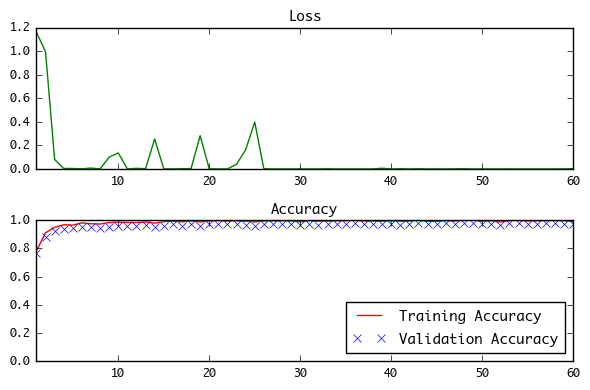

Training Accuracy = 0.990
Validation Accuracy = 0.971


In [218]:
# Measurements use for graphing loss and accuracy
log_epoch_step = 1
epochs = []
loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_tr)
    batch_count = int(math.ceil(num_examples / BATCH_SIZE))
    l = float('inf')
    training_accuracy = 0
    validation_accuracy = 0
    
    for i in range(EPOCHS):
        X_tr, y_tr = shuffle(X_tr, y_tr)
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(i+1, EPOCHS), unit='batches')
        
        for batch_i in batches_pbar:
            offset = batch_i * BATCH_SIZE
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_tr[offset:end], y_tr[offset:end]
            _, l = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
            
        # Log every log_epoch_step batches
        if not batch_i % log_epoch_step:
            # Calculate Training and Validation accuracy
            training_accuracy = evaluate(X_tr, y_tr)
            validation_accuracy = evaluate(X_validation, y_validation)

            # Log epochs
            previous_epoch = epochs[-1] if epochs else 0
            epochs.append(log_epoch_step + previous_epoch)
            loss_epoch.append(l)
            train_acc_epoch.append(training_accuracy)
            valid_acc_epoch.append(validation_accuracy)

            print("EPOCH {} ...".format(i+1), flush=True)
            print("Training Accuracy = {:.3f}".format(training_accuracy), flush=True)
            print("Validation Accuracy = {:.3f}".format(validation_accuracy), flush=True)
            print("", flush=True)
        
    saver.save(sess, 'lenet')
    print("Model saved")
    
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(epochs, loss_epoch, 'g')
loss_plot.set_xlim([epochs[0], epochs[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(epochs, train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(epochs, valid_acc_epoch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([epochs[0], epochs[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()
training_accuracy = evaluate(X_tr, y_tr)
validation_accuracy = evaluate(X_validation, y_validation)
print("Training Accuracy = {:.3f}".format(training_accuracy), flush=True)
print("Validation Accuracy = {:.3f}".format(validation_accuracy), flush=True)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [219]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.912


In [209]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.783


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.